## **Using LSTM to classify Amazon fine food review**

**Install required libraries**

In [ ]:
!pip install pandas numpy scikit-learn nltk

In [ ]:
!pip install keras

**Import requird module**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split




**Load dataset**

In [ ]:
import csv
csvfile = '/content/Reviews.csv'
df = pd.read_csv(csvfile)
# df = pd.read_csv(csvfile, header = None, delimiter="\t", quoting=csv.QUOTE_NONE, encoding='utf-8')

In [ ]:
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df.shape

(568454, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


**add label to the review according to the score**
- score < 3 then review --> label -ive
- score > 3 then review --> label +ive
- socre ==3 then review neutral

In [ ]:
df = df[['Score', 'Text']]
df['label'] = df['Score']
df['review'] = df['Text']

df.drop(['Text','Score'], axis=1, inplace=True)
df.head()

# drop those review having a score/label ==3

df = df[df['label'] !=3 ]

def mark_sentiement(rating):
  if rating < 3:
    return 0 # negative review
  else:
    return 1 # positive review

df['label'] = df['label'].apply(mark_sentiement)

<ipython-input-22-72ec4a8ad970>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['Score']
<ipython-input-22-72ec4a8ad970>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df['Text']
<ipython-input-22-72ec4a8ad970>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Text','Score'], axis

check missing values and duplicates

In [ ]:
print(df['label'].isnull().sum())
df['review'].isnull().sum()
df.drop_duplicates(subset=['label','review'],keep='first',inplace=True)

0


the dataset in too larg pick up only 20000 review/datapoint

In [ ]:
pos_df=df.loc[df.label==1,:][:10000]
neg_df=df.loc[df.label==0,:][:10000]
df=pd.concat([pos_df,neg_df],ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True) #perform a random shuffle. It's a good practice to shuffle the data before splitting between a train and test set. That way the sentiment classes are equally distributed over the train and test sets. df = df.reindex(np.random.permutation(df.index))
df.head()

,label,review
0,1,I come from a family of professional gardeners...
1,0,I usually do not feel mislead by reviews but t...
2,0,Please do your research on pet foods and what ...
3,1,"Firstly, I hate orange flavored sodas. They al..."
4,1,Let me preface this by saying I purchased it a...


**Data Distribution**


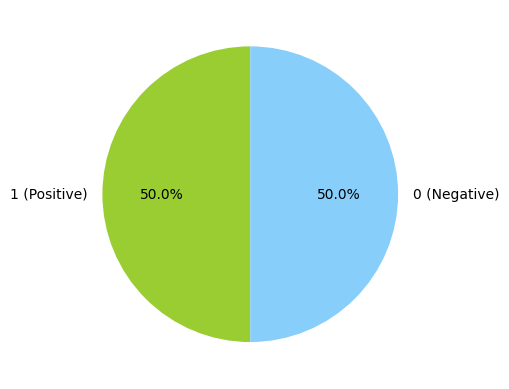

In [ ]:
pie_label = ["1 (Positive)","0 (Negative)"]
pie_colors = ["yellowgreen", "lightskyblue"]
plt.pie(df.label.value_counts(), labels=pie_label, colors=pie_colors, startangle=90, autopct='%.1f%%')
plt.show()

**Data Preprocessing**

In [ ]:
df['review'] = df.review.apply(lambda x : x.lower())  # all reviews characters converts to lowercase
df['review'] = df.review.apply(lambda x: re.sub(r'\d+','', x))  # remove the numbers in reviews
df['review'] = df.review.apply(lambda x: re.sub(r'[^\w\s]', ' ',x)) # remove the punctuations in reviews
df['review'] = df.review.apply(lambda x: x.strip()) # remove whitespaces

**As we know we must include embedding layers in the start of lstm mode when data is comming first the pass through embedding layers to convert into vectors**


**preparing Embedding layers**

In [ ]:
x = df['review']
y = df['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

tokenizer = Tokenizer(num_words=5000)  # Initialize the tokenizer with a 5000 word limit. This is the number of words we would like to encode.
tokenizer.fit_on_texts(x_train) # we call fit_on_texts to create associations of words and numbers

# After having created the dictionary we can convert the text to a list of integer indexes.
# This is done with the text_to_sequences method of the Tokenizer.
# calling text_to_sequence replaces the words in a sentence with their respective associated numbers.
# This transforms each sentence into sequences of numbers.
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
print(x_train)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



**Padding to dataset that all review are of equall size**

In [ ]:
# The reviews have different number of words, therefore, the length of the sequence of numbers will be different.
# Our model requires inputs to have equal lengths, so we will have to pad the sequence to have the chosen length of inputs.
# This is done by calling the pad_sequence method with a length of 200.
vocab_size = len(tokenizer.word_index) + 1

max_review_length = 200

x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)
print(x_train.shape)

(16000, 200)


In [ ]:
print(vocab_size)

24538


## prepare model for training

**Model 1**

In [ ]:
model = Sequential()
embedding_vector_lenght=32
model.add(Embedding(vocab_size,embedding_vector_lenght, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

# start model training
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=5)
result = model.evaluate(x_test, y_test, verbose=0)

# print train model result
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Epoch 1/5
125/125 [==============================] - 30s 184ms/step - loss: 0.5149 - accuracy: 0.7308 - val_loss: 0.3220 - val_accuracy: 0.8725
Epoch 2/5
125/125 [==============================] - 10s 78ms/step - loss: 0.2637 - accuracy: 0.8966 - val_loss: 0.2844 - val_accuracy: 0.8830
Epoch 3/5
125/125 [==============================] - 10s 79ms/step - loss: 0.2115 - accuracy: 0.9202 - val_loss: 0.2959 - val_accuracy: 0.8842
Epoch 4/5
125/125 [==============================] - 6s 52ms/step - loss: 0.1759 - accuracy: 0.9375 - val_loss: 0.2913 - val_accuracy: 0.8832
Epoch 5/5
125/125 [==============================] - 9s 71ms/step - loss: 0.1555 - accuracy: 0.9445 - val_loss: 0.3200 - val_accuracy: 0.8800
Test Score: 0.3200390040874481
Test Accuracy: 0.8799999952316284
Accuracy: 88.00%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


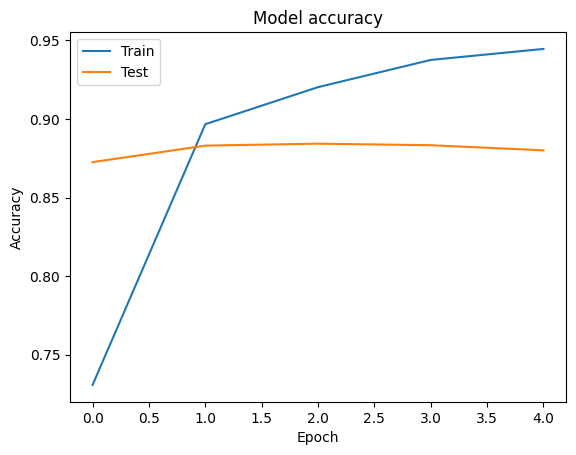

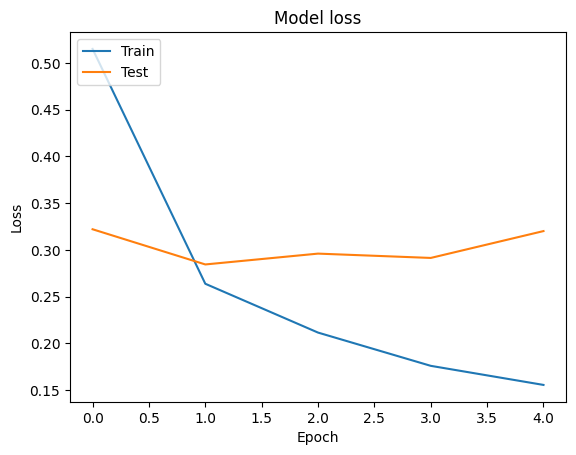

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Model 2**
Embedding -> LSTM -> Dense(Output(Sigmoid))
Same with Model 1 except optimization algorithm. In this study used Adadelta optimizer. With this model, the effect of optimization algorithm is observed.

In [ ]:
model = Sequential()
embedding_vector_lenght=32
model.add(Embedding(vocab_size,embedding_vector_lenght, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='Adadelta', metrics= ['accuracy'])

# start model training
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=5)
result = model.evaluate(x_test, y_test, verbose=0)

# print train model result
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Epoch 1/5
125/125 [==============================] - 18s 122ms/step - loss: 0.6933 - accuracy: 0.4873 - val_loss: 0.6933 - val_accuracy: 0.4823
Epoch 2/5
125/125 [==============================] - 11s 91ms/step - loss: 0.6933 - accuracy: 0.4873 - val_loss: 0.6933 - val_accuracy: 0.4832
Epoch 3/5
125/125 [==============================] - 8s 65ms/step - loss: 0.6933 - accuracy: 0.4877 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 4/5
125/125 [==============================] - 10s 76ms/step - loss: 0.6933 - accuracy: 0.4879 - val_loss: 0.6933 - val_accuracy: 0.4848
Epoch 5/5
125/125 [==============================] - 5s 44ms/step - loss: 0.6933 - accuracy: 0.4888 - val_loss: 0.6933 - val_accuracy: 0.4845
Test Score: 0.6933149695396423
Test Accuracy: 0.484499990940094
Accuracy: 48.45%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


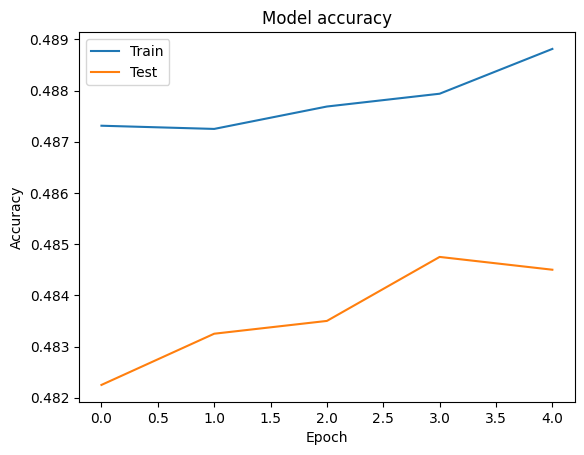

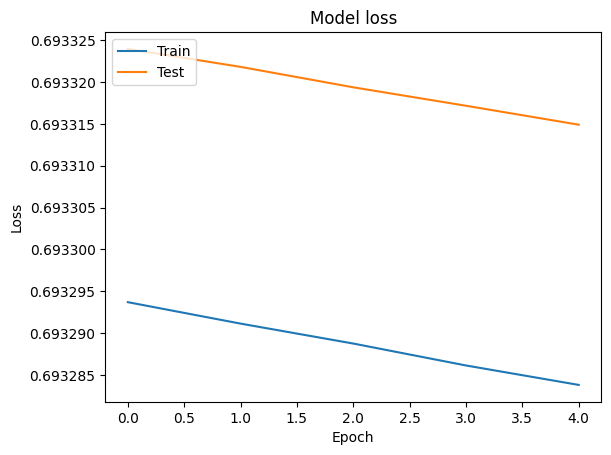

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Model 3**
Embedding -> LSTM -> Dense(Output(Sigmoid))
Same as Model 1, only batch_size different. With this model, the effect of batch size is observed.

In [ ]:
model = Sequential()
embedding_vector_lenght=32
model.add(Embedding(vocab_size,embedding_vector_lenght, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

# start model training
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256, epochs=5)
result = model.evaluate(x_test, y_test, verbose=0)

# print train model result
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Epoch 1/5
63/63 [==============================] - 14s 195ms/step - loss: 0.6218 - accuracy: 0.6749 - val_loss: 0.4674 - val_accuracy: 0.8060
Epoch 2/5
63/63 [==============================] - 8s 122ms/step - loss: 0.3405 - accuracy: 0.8548 - val_loss: 0.2911 - val_accuracy: 0.8825
Epoch 3/5
63/63 [==============================] - 9s 140ms/step - loss: 0.2291 - accuracy: 0.9133 - val_loss: 0.2719 - val_accuracy: 0.8957
Epoch 4/5
63/63 [==============================] - 6s 97ms/step - loss: 0.1908 - accuracy: 0.9311 - val_loss: 0.2858 - val_accuracy: 0.8890
Epoch 5/5
63/63 [==============================] - 5s 80ms/step - loss: 0.1680 - accuracy: 0.9408 - val_loss: 0.2949 - val_accuracy: 0.8810
Test Score: 0.2948843240737915
Test Accuracy: 0.8809999823570251
Accuracy: 88.10%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


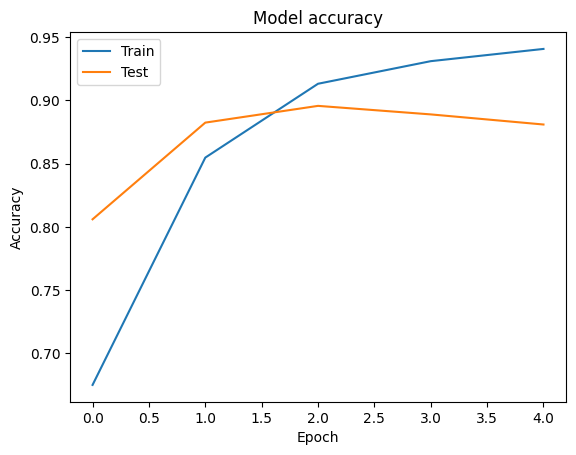

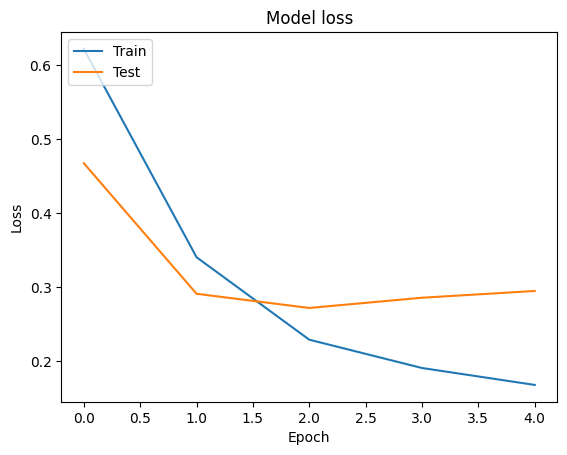

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Model 4**<br> Embedding -> LSTM -> Dense(Output(Sigmoid)) Same as Model 1, used 'relu as activation function'. With this model, the effect of relu is observed.

In [ ]:
model = Sequential()
embedding_vector_lenght=32
model.add(Embedding(vocab_size,embedding_vector_lenght, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

# start model training
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256, epochs=5)
result = model.evaluate(x_test, y_test, verbose=0)

# print train model result
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Epoch 1/5
63/63 [==============================] - 20s 210ms/step - loss: 0.9863 - accuracy: 0.5301 - val_loss: 0.6317 - val_accuracy: 0.7595
Epoch 2/5
63/63 [==============================] - 9s 136ms/step - loss: 0.5311 - accuracy: 0.7841 - val_loss: 0.5585 - val_accuracy: 0.7040
Epoch 3/5
63/63 [==============================] - 7s 110ms/step - loss: 0.4827 - accuracy: 0.7937 - val_loss: 0.5249 - val_accuracy: 0.7825
Epoch 4/5
63/63 [==============================] - 3s 55ms/step - loss: 0.3858 - accuracy: 0.8558 - val_loss: 0.5433 - val_accuracy: 0.8415
Epoch 5/5
63/63 [==============================] - 5s 80ms/step - loss: 0.3503 - accuracy: 0.8857 - val_loss: 0.5344 - val_accuracy: 0.8457
Test Score: 0.5343568325042725
Test Accuracy: 0.8457499742507935
Accuracy: 84.57%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


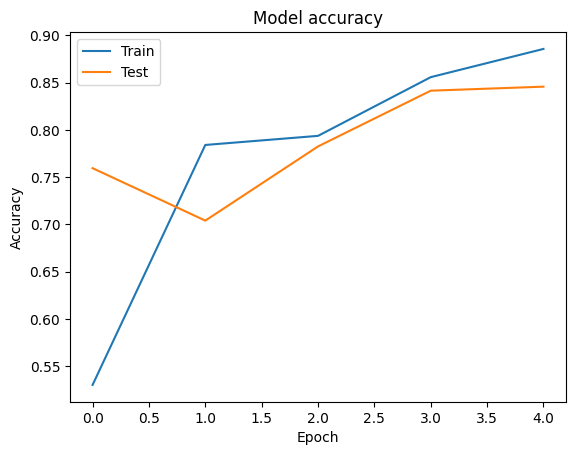

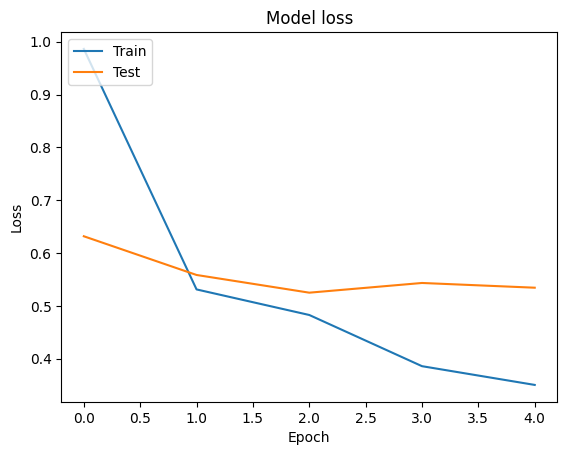

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Model 5**<br>
Embedding -> LSTM -> LSTM -> Dense(Output(Sigmoid))

In [ ]:
model = Sequential()
embedding_vector_lenght=32
model.add(Embedding(vocab_size,embedding_vector_lenght, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1, activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

# start model training
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256, epochs=5)
result = model.evaluate(x_test, y_test, verbose=0)

# print train model result
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Epoch 1/5
63/63 [==============================] - 14s 174ms/step - loss: 0.7941 - accuracy: 0.6121 - val_loss: 0.5604 - val_accuracy: 0.7125
Epoch 2/5
63/63 [==============================] - 7s 108ms/step - loss: 0.4751 - accuracy: 0.8045 - val_loss: 0.4237 - val_accuracy: 0.8422
Epoch 3/5
63/63 [==============================] - 6s 96ms/step - loss: 0.3726 - accuracy: 0.8888 - val_loss: 0.3568 - val_accuracy: 0.8690
Epoch 4/5
63/63 [==============================] - 5s 78ms/step - loss: 0.3620 - accuracy: 0.8991 - val_loss: 0.4379 - val_accuracy: 0.8270
Epoch 5/5
63/63 [==============================] - 4s 69ms/step - loss: 0.3322 - accuracy: 0.8953 - val_loss: 0.6466 - val_accuracy: 0.8705
Test Score: 0.6465883851051331
Test Accuracy: 0.8705000281333923
Accuracy: 87.05%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


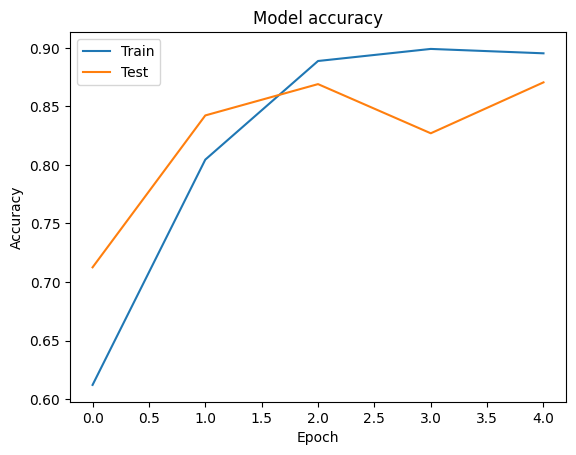

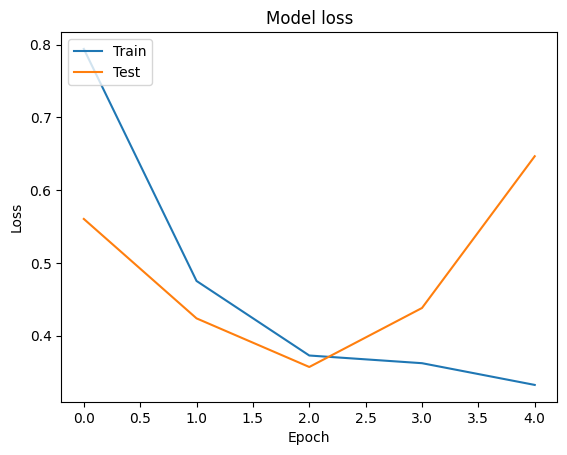

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Model 6**<br>
Embedding -> LSTM -> LSTM -> Dense(Output(*sigmoid*))

In [ ]:
model = Sequential()
embedding_vector_lenght=32
model.add(Embedding(vocab_size,embedding_vector_lenght, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

# start model training
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256, epochs=5)
result = model.evaluate(x_test, y_test, verbose=0)

# print train model result
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Epoch 1/5
63/63 [==============================] - 13s 142ms/step - loss: 0.5076 - accuracy: 0.7306 - val_loss: 0.3431 - val_accuracy: 0.8587
Epoch 2/5
63/63 [==============================] - 8s 125ms/step - loss: 0.2750 - accuracy: 0.8911 - val_loss: 0.2897 - val_accuracy: 0.8777
Epoch 3/5
63/63 [==============================] - 7s 115ms/step - loss: 0.2013 - accuracy: 0.9252 - val_loss: 0.3015 - val_accuracy: 0.8720
Epoch 4/5
63/63 [==============================] - 5s 87ms/step - loss: 0.1854 - accuracy: 0.9315 - val_loss: 0.3115 - val_accuracy: 0.8780
Epoch 5/5
63/63 [==============================] - 4s 67ms/step - loss: 0.1518 - accuracy: 0.9450 - val_loss: 0.3262 - val_accuracy: 0.8788
Test Score: 0.32620367407798767
Test Accuracy: 0.8787500262260437
Accuracy: 87.88%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


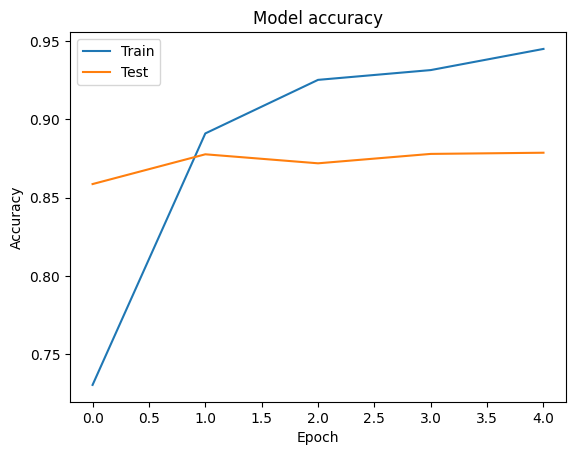

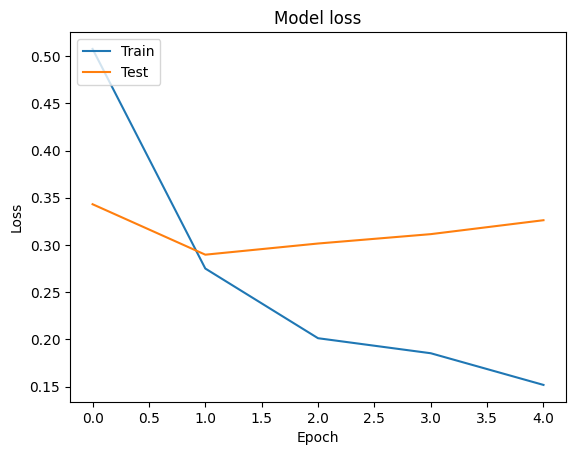

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Model 7**<br>
Embedding -> LSTM -> Dropout -> LSTM -> Dropout -> Dense(Output(Sigmoid))

In [ ]:
model = Sequential()
embedding_vector_lenght=32
model.add(Embedding(vocab_size,embedding_vector_lenght, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

# start model training
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256, epochs=5)
result = model.evaluate(x_test, y_test, verbose=0)

# print train model result
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Epoch 1/5
63/63 [==============================] - 14s 159ms/step - loss: 0.8196 - accuracy: 0.5702 - val_loss: 0.5973 - val_accuracy: 0.7295
Epoch 2/5
63/63 [==============================] - 6s 100ms/step - loss: 0.5724 - accuracy: 0.7799 - val_loss: 0.5272 - val_accuracy: 0.8117
Epoch 3/5
63/63 [==============================] - 6s 96ms/step - loss: 0.4419 - accuracy: 0.8354 - val_loss: 0.4990 - val_accuracy: 0.8357
Epoch 4/5
63/63 [==============================] - 5s 79ms/step - loss: 0.4026 - accuracy: 0.8599 - val_loss: 0.4107 - val_accuracy: 0.8385
Epoch 5/5
63/63 [==============================] - 5s 80ms/step - loss: 0.5016 - accuracy: 0.7778 - val_loss: 0.4906 - val_accuracy: 0.7837
Test Score: 0.49055516719818115
Test Accuracy: 0.7837499976158142
Accuracy: 78.37%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


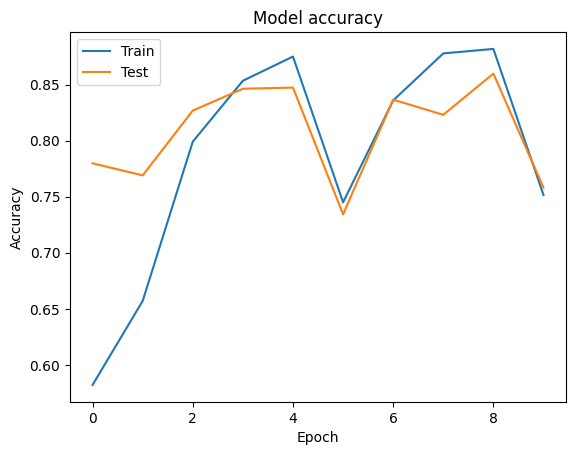

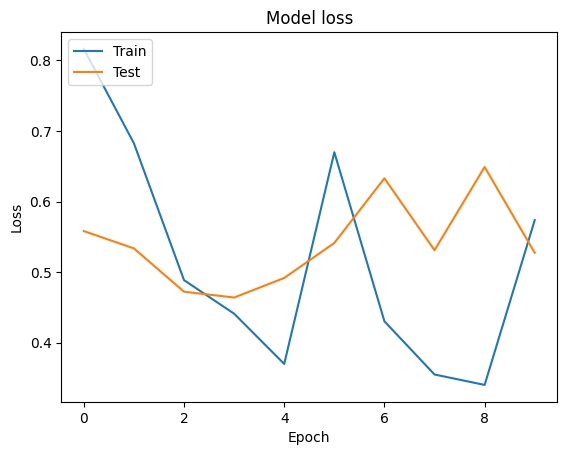

In [ ]:

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Model 8**<br>
Embedding -> LSTM -> Dense(activation:Relu) -> Dense(Output(Sigmoid))
With this model, the effect of activation function is observed.

In [ ]:
model = Sequential()
embedding_vector_lenght=32
model.add(Embedding(vocab_size,embedding_vector_lenght, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(Dense(64,  kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

# start model training
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=5)
result = model.evaluate(x_test, y_test, verbose=0)

# print train model result
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Epoch 1/5
125/125 [==============================] - 18s 127ms/step - loss: 0.6651 - accuracy: 0.5681 - val_loss: 0.6111 - val_accuracy: 0.6224
Epoch 2/5
125/125 [==============================] - 12s 101ms/step - loss: 0.5945 - accuracy: 0.6224 - val_loss: 0.6017 - val_accuracy: 0.6235
Epoch 3/5
125/125 [==============================] - 9s 71ms/step - loss: 0.5690 - accuracy: 0.6399 - val_loss: 0.5974 - val_accuracy: 0.6282
Epoch 4/5
125/125 [==============================] - 6s 44ms/step - loss: 0.5568 - accuracy: 0.6457 - val_loss: 0.6290 - val_accuracy: 0.6251
Epoch 5/5
125/125 [==============================] - 4s 29ms/step - loss: 0.5477 - accuracy: 0.6500 - val_loss: 0.6320 - val_accuracy: 0.6262
Test Score: 0.6320365071296692
Test Accuracy: 0.626248836517334
Accuracy: 62.62%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


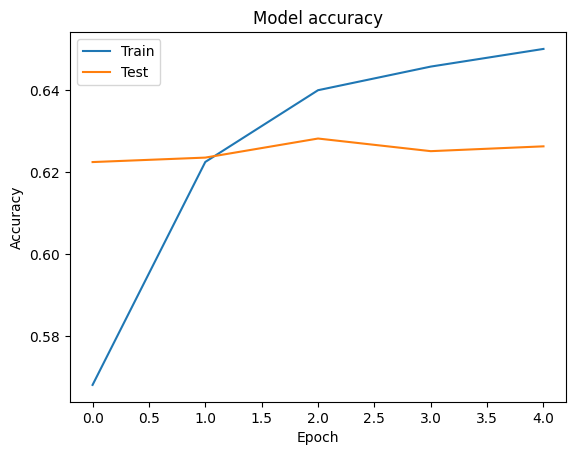

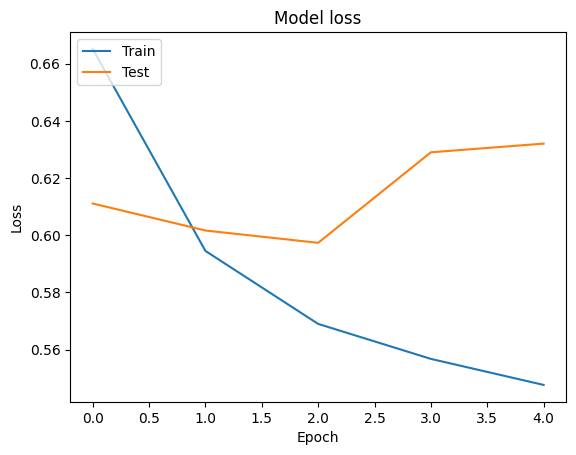

In [ ]:

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Model 9**<br>
Embedding -> LSTM -> Dense(activation:Softmax) -> Dense(Output(Sigmoid))
With this model, the effect of activation function is observed

In [ ]:
model = Sequential()
embedding_vector_lenght=32
model.add(Embedding(vocab_size,embedding_vector_lenght, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(Dense(64,  kernel_initializer='uniform', activation='softmax'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

# start model training
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=30)
result = model.evaluate(x_test, y_test, verbose=0)

# print train model result
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Epoch 1/30
125/125 [==============================] - 16s 108ms/step - loss: 0.6915 - accuracy: 0.5177 - val_loss: 0.6860 - val_accuracy: 0.5603
Epoch 2/30
125/125 [==============================] - 9s 72ms/step - loss: 0.6779 - accuracy: 0.5791 - val_loss: 0.6697 - val_accuracy: 0.6004
Epoch 3/30
125/125 [==============================] - 6s 51ms/step - loss: 0.6655 - accuracy: 0.5990 - val_loss: 0.6618 - val_accuracy: 0.6049
Epoch 4/30
125/125 [==============================] - 6s 47ms/step - loss: 0.6599 - accuracy: 0.6034 - val_loss: 0.6596 - val_accuracy: 0.6050
Epoch 5/30
125/125 [==============================] - 5s 39ms/step - loss: 0.6656 - accuracy: 0.5856 - val_loss: 0.6531 - val_accuracy: 0.6086
Epoch 6/30
125/125 [==============================] - 4s 34ms/step - loss: 0.6378 - accuracy: 0.6210 - val_loss: 0.6355 - val_accuracy: 0.6177
Epoch 7/30
125/125 [==============================] - 4s 31ms/step - loss: 0.6236 - accuracy: 0.6159 - val_loss: 0.6284 - val_accuracy: 0.61

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


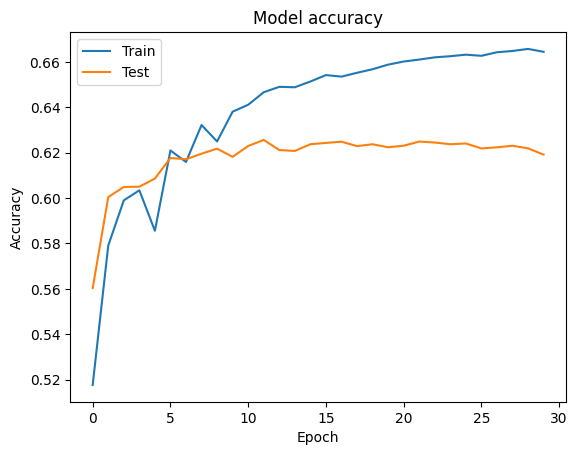

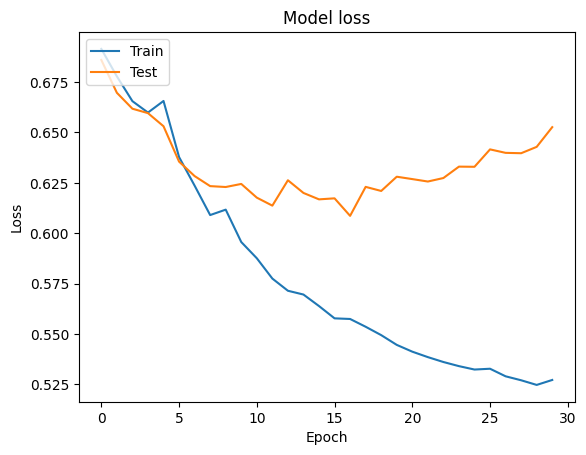

In [ ]:

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Model 10**<br>
Embedding -> LSTM -> Dense(activation:Softmax) -> Dense(Output(relu))
With this model, the effect of activation function is observed

In [ ]:
model = Sequential()
embedding_vector_lenght=32
model.add(Embedding(vocab_size,embedding_vector_lenght, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(Dense(64,  kernel_initializer='uniform', activation='softmax'))
model.add(Dense(1, activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

# start model training
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=30)
result = model.evaluate(x_test, y_test, verbose=0)

# print train model result
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Epoch 1/30
125/125 [==============================] - 16s 107ms/step - loss: 7.6922 - accuracy: 0.5013 - val_loss: 7.7935 - val_accuracy: 0.4947
Epoch 2/30
125/125 [==============================] - 9s 72ms/step - loss: 7.6922 - accuracy: 0.5013 - val_loss: 7.7935 - val_accuracy: 0.4947
Epoch 3/30
125/125 [==============================] - 7s 57ms/step - loss: 7.6922 - accuracy: 0.5013 - val_loss: 7.7935 - val_accuracy: 0.4947
Epoch 4/30
125/125 [==============================] - 6s 52ms/step - loss: 7.6922 - accuracy: 0.5013 - val_loss: 7.7935 - val_accuracy: 0.4947
Epoch 5/30
125/125 [==============================] - 4s 29ms/step - loss: 7.6922 - accuracy: 0.5013 - val_loss: 7.7935 - val_accuracy: 0.4947
Epoch 6/30
125/125 [==============================] - 3s 26ms/step - loss: 7.6922 - accuracy: 0.5013 - val_loss: 7.7935 - val_accuracy: 0.4947
Epoch 7/30
125/125 [==============================] - 5s 37ms/step - loss: 7.6922 - accuracy: 0.5013 - val_loss: 7.7935 - val_accuracy: 0.49

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


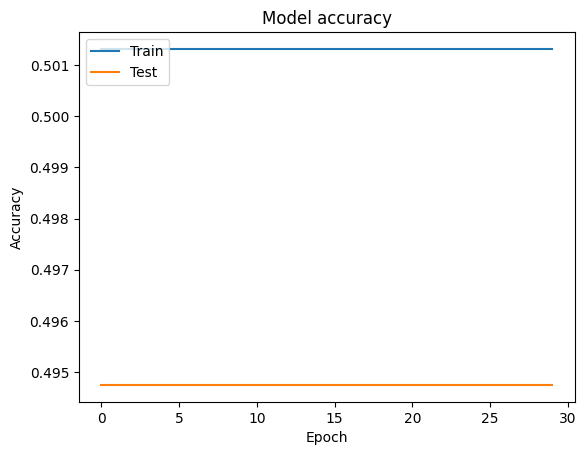

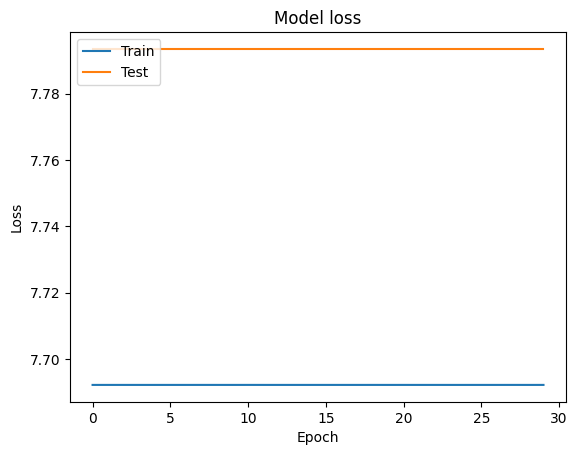

In [ ]:

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()